In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os as os

path = "./results"

The load_curves function loads the results of multiple algorithms across different environments from .npy files, stores them in a dictionary structure, and processes them to ensure the curves all have the same length.

In [2]:
def load_curves(algorithms, envs, batch_sizes, hidden_sizes, t, path):
    """
    Load and process curves from saved files based on algorithms, environments, batch sizes, and hidden sizes.

    Args:
        algorithms (list): List of algorithm names.
        envs (list): List of environment names.
        batch_sizes (list): List of batch sizes used in the experiments.
        hidden_sizes (list): List of hidden sizes used in the experiments.
        t (int): Type of file to load (0 for regular, 1 for "_s" suffix).
        path (str): Path to the directory containing the data files.

    Returns:
        dict: Nested dictionary of curves {algorithm -> environment -> batch_size -> hidden_size -> [curves]}.
    """
    curves = {
        alg: {e: {hs: {bs: [] for bs in batch_sizes} for hs in hidden_sizes} for e in envs}
        for alg in algorithms
    }

    for alg in algorithms:
        for e in envs:
            for hidden_size in hidden_sizes:
                for batch_size in batch_sizes:
                    for i in range(0, 100):
                        suffix = "_s" if t == 1 else ""
                        name = f"{path}/{alg}_{hidden_size}_{batch_size}_{e}_{i}{suffix}.npy"
                        
                        if os.path.isfile(name):
                            curves[alg][e][hidden_size][batch_size].append(list(np.load(name)))
            
                    # Normalize the lengths of all curves for the current configuration
                    max_size = max(
                        (len(curve) for curve in curves[alg][e][hidden_size][batch_size]), default=-1
                    )
                    for i in range(len(curves[alg][e][hidden_size][batch_size])):
                        while len(curves[alg][e][hidden_size][batch_size][i]) < max_size:
                            curves[alg][e][hidden_size][batch_size][i].append(
                                curves[alg][e][hidden_size][batch_size][i][-1]
                            )

                    # Convert to numpy array for further processing
                    curves[alg][e][hidden_size][batch_size] = (
                        np.array(curves[alg][e][hidden_size][batch_size])
                        if len(curves[alg][e][hidden_size][batch_size]) else np.array([[]])
                    )

    return curves


The smooth function applies a smoothing technique to the loaded data by averaging over a window of neighboring points, creating a more visually appealing curve by reducing fluctuations.

In [3]:
def smooth(data, length=10):
    data = data.copy()
    pad = data[:, 0, None].repeat(length-1, axis=-1)
    pad_data = np.concatenate((pad, data), axis=-1)
    for i in range(len(data[0])):
        data[:, i] = np.mean(pad_data[:, i:i+length], axis=-1)
    return data

Compute the Frequency

In [4]:
def get_comput_freq(policy, batch_size, hidden_size):
    """
    Determines the computation frequency based on the policy, batch size, and hidden size.

    Args:
        policy (str): The name of the policy (e.g., "TD3", "ExpD3", etc.).
        batch_size (int): The batch size parameter.
        hidden_size (int): The hidden size parameter.

    Returns:
        float: The computation frequency (Hz).
    """
    if policy == "TD3":
        if batch_size == 32 and hidden_size == 32:
            return 1/20  # ~20 Hz
        elif batch_size == 64 and hidden_size == 32:
            return 1/17  # ~17 Hz
        elif batch_size == 128 and hidden_size == 32:
            return 1/12  # ~12 Hz
        elif batch_size == 32 and hidden_size == 64:
            return 1/13  # ~13 Hz
        elif batch_size == 64 and hidden_size == 64:
            return 1/9  # ~9 Hz
        elif batch_size == 128 and hidden_size == 64:
            return 1/5.9  # ~5.9 Hz
    elif policy == "OurDDPG":
        if batch_size == 32 and hidden_size == 32:
            return 1/20  
        elif batch_size == 64 and hidden_size == 32:
            return 1/17 
        elif batch_size == 128 and hidden_size == 32:
            return 1/12 
        elif batch_size == 32 and hidden_size == 64:
            return 1/13.7 
        elif batch_size == 64 and hidden_size == 64:
            return 1/9 
        elif batch_size == 128 and hidden_size == 64:
            return 1/5.8  
    elif policy == "ExpD3":
        if batch_size == 32 and hidden_size == 32:
            return 1/26  # ~26 Hz
        elif batch_size == 64 and hidden_size == 32:
            return 1/22  # ~22 Hz
        elif batch_size == 128 and hidden_size == 32:
            return 1/16.8  # ~16.8 Hz
        elif batch_size == 32 and hidden_size == 64:
            return 1/17  # ~17 Hz
        elif batch_size == 64 and hidden_size == 64:
            return 1/12.7  # ~12.7 Hz
        elif batch_size == 128 and hidden_size == 64:
            return 1/8  # ~8 Hz
    elif policy == "SAC":
        if batch_size == 32 and hidden_size == 32:
            return 1/20  
        elif batch_size == 64 and hidden_size == 32:
            return 1/17  
        elif batch_size == 128 and hidden_size == 32:
            return 1/12  
        elif batch_size == 32 and hidden_size == 64:
            return 1/13  
        elif batch_size == 64 and hidden_size == 64:
            return 1/9  
        elif batch_size == 128 and hidden_size == 64:
            return 1/5.9

    # Default frequency if no specific case matches
    return 1/10  # ~10 Hz

Plot the results

In [5]:
def plot_results_grid(ENVS, ALGORITHMS, BATCH_SIZES, HIDDEN_SIZES, curves, use_median):
    """
    Plots the performance curves for multiple algorithms with different batch and hidden sizes
    in a 3x2 grid, with all algorithms overlaid in each plot for different batch/hidden size combinations.
    
    Args:
        ENVS (list): List of environment names.
        ALGORITHMS (list): List of algorithm names.
        BATCH_SIZES (list): List of batch sizes.
        HIDDEN_SIZES (list): List of hidden sizes.
        curves (dict): Data for each algorithm, environment, batch size, and hidden size.
        use_median (bool): If True, use median with quartiles; if False, use mean with std deviation.
    """
    # Create the 3x2 grid of subplots
    fig, axes = plt.subplots(3, 2, sharex=True, figsize=(15, 10))
    axes = axes.flatten()  # Flatten the grid of axes for easier indexing

    # Loop over the grid of subplots (batch size and hidden size combinations)
    for idx, (hidden_size, batch_size) in enumerate([(32, 32), (64, 32), (32, 64), (64, 64), (32, 128), (64, 128)]):
        ax = axes[idx]  # Get the corresponding axis for this grid location
        ax.set_title(f"Batch {batch_size}, Neurons {hidden_size}", fontsize=16)
        ax.set_xlabel("Time [hours]")
        ax.set_ylabel("Success Rate" if use_median else "Reward")

        # Loop through each algorithm and plot its data for the current batch_size and hidden_size
        for alg_idx, alg in enumerate(ALGORITHMS):
            c = curves[alg][ENVS[0]][hidden_size][batch_size]
            if c.size == 0:
                print(f"No data for {alg} on {ENVS[0]} with batch {batch_size} and neurons {hidden_size}. Skipping.")
                continue

            # Get computation frequency for this combination
            delta_t = get_comput_freq(alg, batch_size, hidden_size)

            # Compute the time axis based on the sampling rate
            x = np.arange(c.shape[1]) * delta_t

            # Plot using median or mean depending on `use_median`
            if use_median:
                # Median and quartiles
                median = smooth(np.median(c, axis=0, keepdims=True), length=2).squeeze()
                q1 = smooth(np.percentile(c, 25, axis=0, keepdims=True), length=2).squeeze()
                q3 = smooth(np.percentile(c, 75, axis=0, keepdims=True), length=2).squeeze()
                ax.plot(x, median, label=f"{alg}", linewidth=2)
                ax.fill_between(x, q1, q3, alpha=0.2)
            else:
                # Mean and standard deviation
                mu = smooth(c.mean(axis=0, keepdims=True), length=2).squeeze()
                sigma = smooth(c.std(axis=0, keepdims=True), length=2).squeeze()
                ax.plot(x, mu, label=f"{alg}", linewidth=2)
                ax.fill_between(x, mu + sigma, mu - sigma, alpha=0.2)

        # Add grid and legend for each plot
        ax.grid(True)
        ax.legend(loc='best')

    # Adjust layout for better spacing and add a title for the entire figure
    fig.suptitle("Comparison of Algorithms across Batch and Neural Net Sizes", fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to avoid title overlap
    plt.show()


In [6]:
# Define parameters
ENVS = ['MR-env']
ALGORITHMS = ['OurDDPG', 'ExpD3', 'TD3', 'SAC']
BATCH_SIZES = [32, 64, 128]
HIDDEN_SIZES = [32, 64]

Plots the performance curves for each algorithm on each environment.

No data for SAC on MR-env with batch 32 and neurons 32. Skipping.
No data for SAC on MR-env with batch 32 and neurons 64. Skipping.
No data for SAC on MR-env with batch 64 and neurons 32. Skipping.
No data for SAC on MR-env with batch 64 and neurons 64. Skipping.
No data for SAC on MR-env with batch 128 and neurons 32. Skipping.
No data for SAC on MR-env with batch 128 and neurons 64. Skipping.


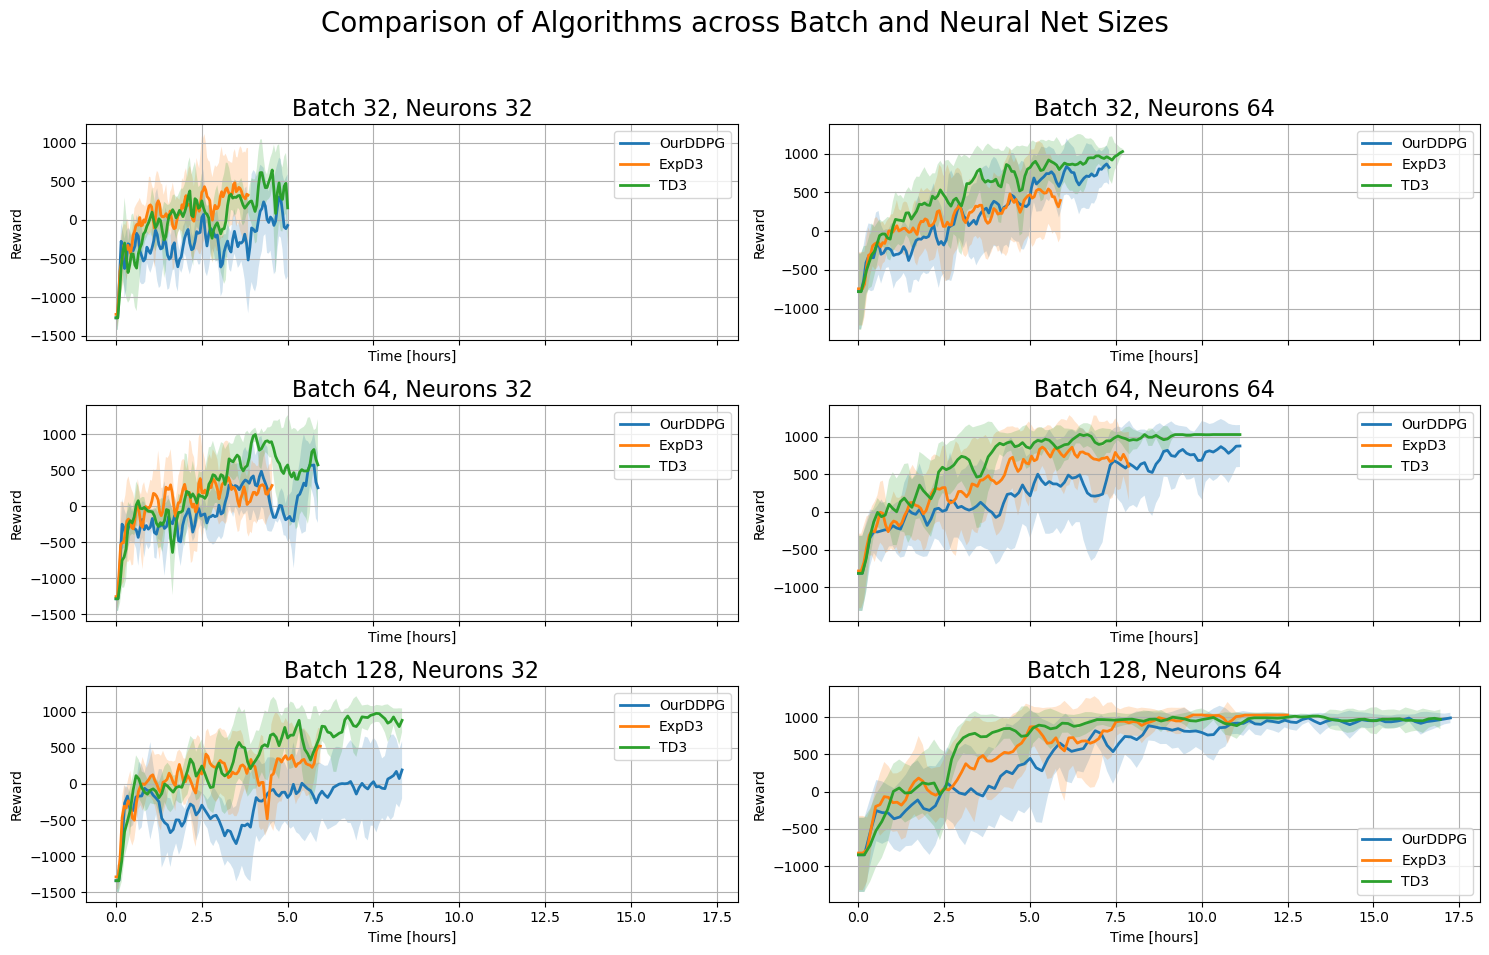

In [7]:
t = 0
# Load curves
curves = load_curves(ALGORITHMS, ENVS, BATCH_SIZES, HIDDEN_SIZES, t, path)
# Plot results
plot_results_grid(ENVS, ALGORITHMS, BATCH_SIZES, HIDDEN_SIZES, curves, use_median=False)

No data for SAC on MR-env with batch 32 and neurons 32. Skipping.
No data for SAC on MR-env with batch 32 and neurons 64. Skipping.
No data for SAC on MR-env with batch 64 and neurons 32. Skipping.
No data for SAC on MR-env with batch 64 and neurons 64. Skipping.
No data for SAC on MR-env with batch 128 and neurons 32. Skipping.
No data for SAC on MR-env with batch 128 and neurons 64. Skipping.


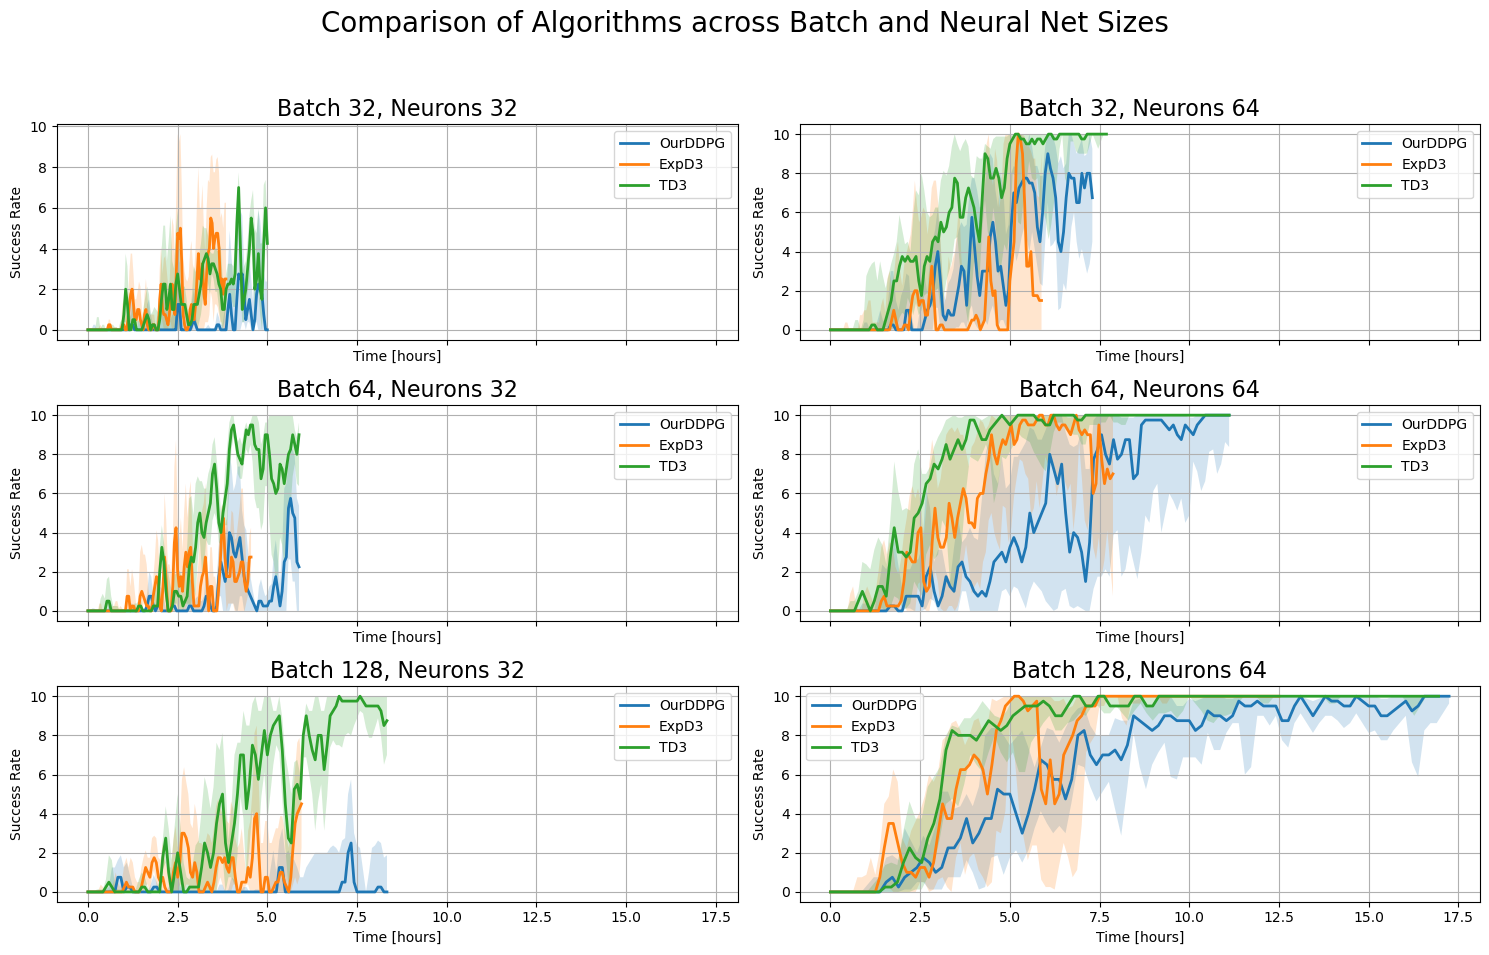

In [8]:
t = 1
# Load curves
curves = load_curves(ALGORITHMS, ENVS, BATCH_SIZES, HIDDEN_SIZES, t, path)
# Plot results
plot_results_grid(ENVS, ALGORITHMS, BATCH_SIZES, HIDDEN_SIZES, curves, use_median=True)